# CSC475/575 Spring 2024 - Assignment 5

This assignment covers topics related to embeddings, manifold-learning 
and visualization  

* A5.1: Manifold learning plots PCA, LDA with meanMFCC and mean_stdMFCC 
* A5.2: Manifold learning plots t-SNE with meanMFCC and mean_stdMFCC 
* A5.3: Classification using PCA-2, PCA-3, PCA-10 
* A5.4: Classification using t-SNE-2, t-SNE-3 
* A5.5: Adding interaction 

Each question is worth 2 points for a total of 10 points for the assignment. 

In [2]:
# your code goes here 
import glob
import librosa
import soundfile
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm, metrics, neighbors, ensemble, linear_model
from sklearn.model_selection import cross_val_predict
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.neighbors import NearestNeighbors

#### **Question A5.1(basic): Manifold learning** 
 
You will be using the fma_smaller dataset you created for the previous assignment containing 4000 tracks from 4 genres. 

Create embedding plots (similar to the ones we looked at in class) using 
Use the following two dimensionality reduction methods: Principal Component Analysis -  PCA (unsupervised), Linear Discriminant Analysis - LDA (supervised). Color the points of the two plots based on the original ground truth labels. 

 (**Basic: 2 points**)


In [3]:
genres = ['folk', 'hiphop', 'instrumental', 'rock']

fnames = glob.glob('../fma_smaller/*/*.wav')

mean_mfcc_features = np.zeros((len(fnames), 20))
target = np.zeros(len(fnames))

# compute the features 
for (i,fname) in enumerate(fnames): 
    for (label,genre) in enumerate(genres): 
        if genre in fname: 
            audio, srate = librosa.load(fname)

            mfcc_matrix = librosa.feature.mfcc(y=audio, sr=srate)
            mean_mfcc = np.mean(mfcc_matrix,axis=1)

            mean_mfcc_features[i] = mean_mfcc

            #assign ground truth label
            target[i] = label

print(mean_mfcc_features.shape)


(3996, 20)


In [4]:
X1 = mean_mfcc_features
y1 = target

In [5]:
colors = ['tab:orange','tab:green', 'tab:purple', 'tab:blue']
def plot_scatter(X, y, title): 
    lw = 2
    #fig = plt.figure(1, figsize=(8, 6))
    for color, i, target_name in zip(colors, [0,1,2,3], genres):
        plt.scatter(X[y == i, 0], X[y == i, 1], color=color, alpha=.5, 
                    lw=lw, label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title(title)
    plt.show()

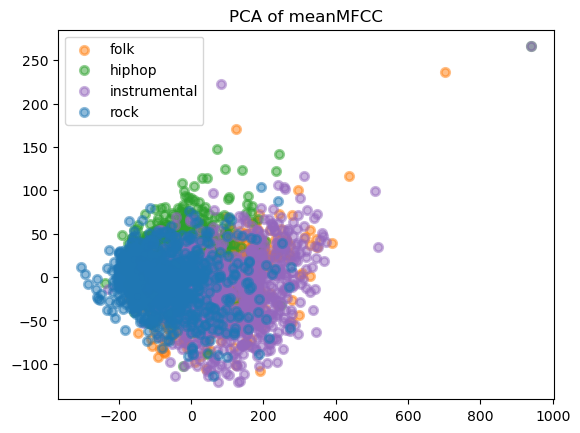

In [30]:
# Two dimensional PCA 
X_pca = PCA(n_components=2).fit_transform(X1)
plot_scatter(X_pca, y1, 'PCA of meanMFCC')

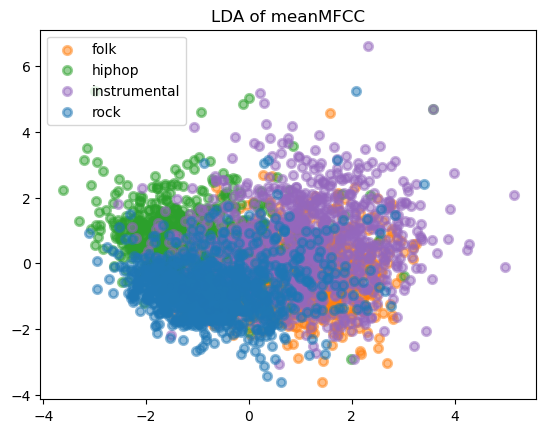

In [29]:
# Two dimensional LDA 
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X1,y1)
plot_scatter(X_lda, y1, 'LDA of meanMFCC')

#### **Question A5.2 (basic): Manifold learning with different features** 

Repeat the manifold learning plots from the previous question but this time using the mean_stdMFCC features. Comment on what differences you observe in the plots. Which feature set works better for visualization purposes. 

 (**Basic: 2 points**)


In [8]:
#Obtain MFCCs for each song in order to create a dataset for feature reduction bia PCA and LDA

genres = ['folk', 'hiphop', 'instrumental', 'rock']

fnames = glob.glob('../fma_smaller/*/*.wav')

mfcc_features = np.zeros((len(fnames), 40))
target = np.zeros(len(fnames))

# compute the features 
for (i,fname) in enumerate(fnames): 
    for (label,genre) in enumerate(genres): 
        if genre in fname: 
            audio, srate = librosa.load(fname)

            mfcc_matrix = librosa.feature.mfcc(y=audio, sr=srate)
            mean_mfcc = np.mean(mfcc_matrix,axis=1)
            std_mfcc = np.std(mfcc_matrix, axis=1)

            mfcc_fvec = np.concatenate([mean_mfcc, std_mfcc])
            mfcc_features[i] = mfcc_fvec

            #assign ground truth label
            target[i] = label

print(mfcc_features.shape)

(3996, 40)


In [9]:
X2 = mfcc_features
y2 = target

In [10]:
colors = ['tab:orange','tab:green', 'tab:purple', 'tab:blue']
def plot_scatter(X, y, title): 
    lw = 2
    #fig = plt.figure(1, figsize=(8, 6))
    for color, i, target_name in zip(colors, [0,1,2,3], genres):
        plt.scatter(X[y == i, 0], X[y == i, 1], color=color, alpha=.5, 
                    lw=lw, label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title(title)
    plt.show()

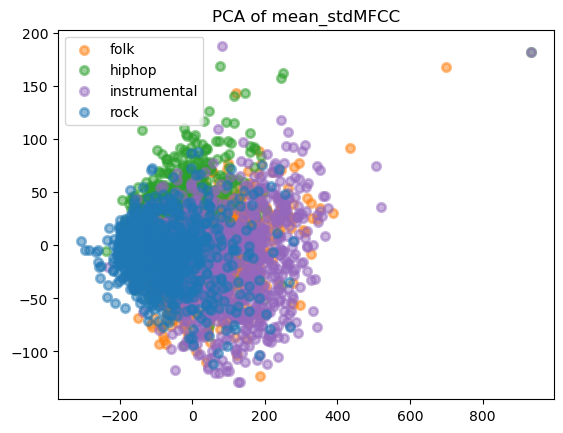

In [27]:
# Two dimensional PCA 
X_pca = PCA(n_components=2).fit_transform(X2)
plot_scatter(X_pca, y2, 'PCA of mean_stdMFCC')

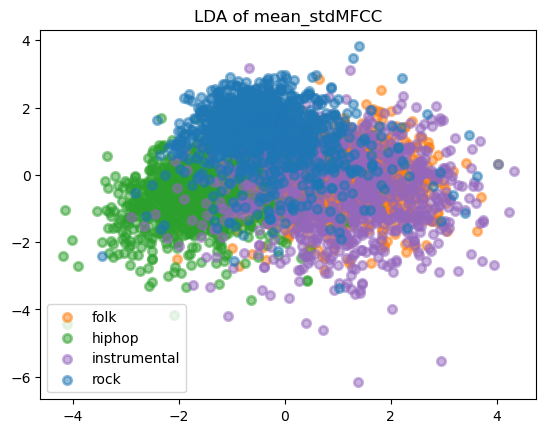

In [28]:
# Two dimensional LDA 
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X2,y2)
plot_scatter(X_lda, y2, 'LDA of mean_stdMFCC')

Overall the mean_stdMFCC slightly beats the meanMFCC. The difference being extra noticeable in the LDA plot, with all genres spreading further from rock, which seems to be the central genre. PCA also has more spreading when use mean_stdMFCC, but its less noticeable as PCA already had much less spread than LDA to begin with. 
  
furthermore, the addition of the std features seems to have flipped the LDA around the x-axis which is interesting.

#### **Question A5.3 (expected): Classification using embeddings ** 

Using the dimensionality reduced points perform classification of the dataset i.e instead of the original feature vector use the 2D embedding vectors(points) that you calculated. Compare the classification accuracy of the PCA embeddings in two dimensions with the classification accuracy obtained using the original features. In addition use PCA with 3 components and PCA with 10 components. 
Use 5-fold cross-validation and the support vector machine classifier with default features for all the configurations: orginal, PCA-2, PCA-3, and PCA-10. 

 (**Expected: 2 points**)


In [22]:
#Using the mean_stdMFCC for this question, as it has marginally better seperation in PCA

X_pca2 = PCA(n_components=2).fit_transform(X2)

X_pca3 = PCA(n_components=3).fit_transform(X2)

X_pca10 = PCA(n_components=10).fit_transform(X2)


In [23]:
# 5 fold cross validation of SVM trained on mean_stdMFCC vs the PCA reduced features of mean_stdMFCC

clf = svm.SVC()
y_pred = cross_val_predict(clf, X2, y2, cv=5)
print('Accuracy for SVM trained on mean_stdMFCC: ', metrics.accuracy_score(y2, y_pred)) 

y_pred = cross_val_predict(clf, X_pca2, y2, cv=5)
print('Accuracy for SVM trained on PCA reduced features (2d): ', metrics.accuracy_score(y2, y_pred))

y_pred = cross_val_predict(clf, X_pca3, y2, cv=5)
print('Accuracy for SVM trained on PCA reduced features (3d): ', metrics.accuracy_score(y2, y_pred))

y_pred = cross_val_predict(clf, X_pca10, y2, cv=5)
print('Accuracy for SVM trained on PCA reduced features (10d): ', metrics.accuracy_score(y2, y_pred))

Accuracy for SVM trained on mean_stdMFCC:  0.6894394394394394
Accuracy for SVM trained on PCA reduced features (2d):  0.5758258258258259
Accuracy for SVM trained on PCA reduced features (3d):  0.6086086086086087
Accuracy for SVM trained on PCA reduced features (10d):  0.6861861861861862


The PCA10 has a remarkably close accuracy to the mfcc_features trained SVM, even though it only has a quarter of the features (10 vs 40)

#### **Question A5.4 (expected): t-SNE** 

Create the plots for the meanMFCC and mean_stdMFCC using the t-SNE method. 
Repeat the classification experiment using the t-SNE. 

 (**Expected: 2 points**)


(3996, 2)


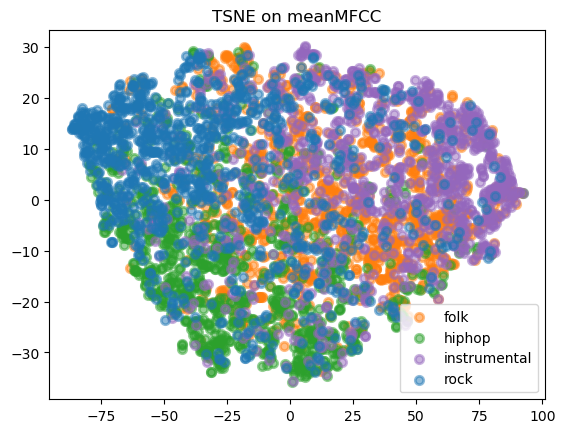

In [20]:
# your code goes here 
tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X1)
print(X_tsne.shape)
plot_scatter(X_tsne, y1, 'TSNE on meanMFCC')

(3996, 2)


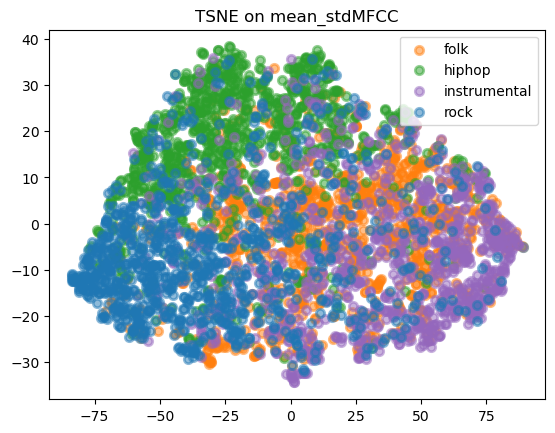

In [21]:
tsne = TSNE(n_components=2, init='pca', random_state=0)
X_tsne = tsne.fit_transform(X2)
print(X_tsne.shape)
plot_scatter(X_tsne, y2, 'TSNE on mean_stdMFCC')

In [25]:
#Again using mean_stdMFCC for this question, as it has marginally better seperation in TSNE

X_tsne2 = TSNE(n_components=2, init='pca', random_state=0).fit_transform(X2)

X_tsne3 = TSNE(n_components=3, init='pca', random_state=0).fit_transform(X2)

#Can't use 10d TSNE as it is not supported by the TSNE function (n_components must be 'inferior to 4')

In [26]:
# 5 fold cross validation of SVM trained on mean_stdMFCC vs the TSNE reduced features of mean_stdMFCC

clf = svm.SVC()
y_pred = cross_val_predict(clf, X2, y2, cv=5)
print('Accuracy for SVM trained on mean_stdMFCC: ', metrics.accuracy_score(y2, y_pred))

y_pred = cross_val_predict(clf, X_tsne2, y2, cv=5)
print('Accuracy for SVM trained on TSNE reduced features (2d): ', metrics.accuracy_score(y2, y_pred))

y_pred = cross_val_predict(clf, X_tsne3, y2, cv=5)
print('Accuracy for SVM trained on TSNE reduced features (3d): ', metrics.accuracy_score(y2, y_pred))

Accuracy for SVM trained on mean_stdMFCC:  0.6894394394394394
Accuracy for SVM trained on TSNE reduced features (2d):  0.6203703703703703
Accuracy for SVM trained on TSNE reduced features (3d):  0.6298798798798799


#### **Question A5.5 (advanced): Graph Visualization from embeddings ** 

Consider a particular point in the embedding space that corresponds to a particular track. Your goal is to create a visualization that shows the relationships it has to neighboring points/tracks. Write a function that takes as argument a track name, the finds the corresponding point in the embedding space, and locates the 10 nearest neighbors. 

Create a new plots that has the track in the middle and the 10 neighboring points placed around it with distances proportional to the distances in the embedding space. Connect the center point with the neighbors using lines and add text to the plot that display the track and artist name. Show 3 examples of these graph plots. 


 (**Advanced: 2 points**)


In [16]:
# your code goes here 